In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


In [3]:
symbol = 'TATAMOTORS.NS'  # Tata Motors on NSE
start_date = '1996-01-01'
end_date = '2023-01-16'

# Fetch historical data
df = yf.download(symbol, start=start_date, end=end_date)
# Display the data
df =df.reset_index()
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)


[*********************100%%**********************]  1 of 1 completed


In [4]:
dataset = new_data.values

train_size = int(len(dataset) * 0.8)
train, valid = dataset[0:train_size, :], dataset[train_size:, :]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60, len(train)):
    x_train.append(scaled_data[i - 60:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [5]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)


Epoch 1/10
5382/5382 - 43s - loss: 7.9961e-04 - 43s/epoch - 8ms/step
Epoch 2/10
5382/5382 - 42s - loss: 2.7337e-04 - 42s/epoch - 8ms/step
Epoch 3/10
5382/5382 - 46s - loss: 2.1754e-04 - 46s/epoch - 9ms/step
Epoch 4/10
5382/5382 - 45s - loss: 1.9542e-04 - 45s/epoch - 8ms/step
Epoch 5/10
5382/5382 - 49s - loss: 1.6666e-04 - 49s/epoch - 9ms/step
Epoch 6/10
5382/5382 - 46s - loss: 1.4600e-04 - 46s/epoch - 9ms/step
Epoch 7/10
5382/5382 - 46s - loss: 1.4920e-04 - 46s/epoch - 9ms/step
Epoch 8/10
5382/5382 - 43s - loss: 1.4480e-04 - 43s/epoch - 8ms/step
Epoch 9/10
5382/5382 - 44s - loss: 1.4604e-04 - 44s/epoch - 8ms/step
Epoch 10/10
5382/5382 - 44s - loss: 1.2630e-04 - 44s/epoch - 8ms/step


In [6]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i - 60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

# Extract the corresponding subset of 'valid' for accurate comparison
valid_predicted = closing_price[-len(valid):]


43/43 [==============================] - 1s 5ms/step


In [7]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print(rms)


8.503624461817084


/var/folders/t4/d3p1kdtx0vg8t_v9svmw8bs40000gn/T/ipykernel_94474/3558570432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = valid_predicted


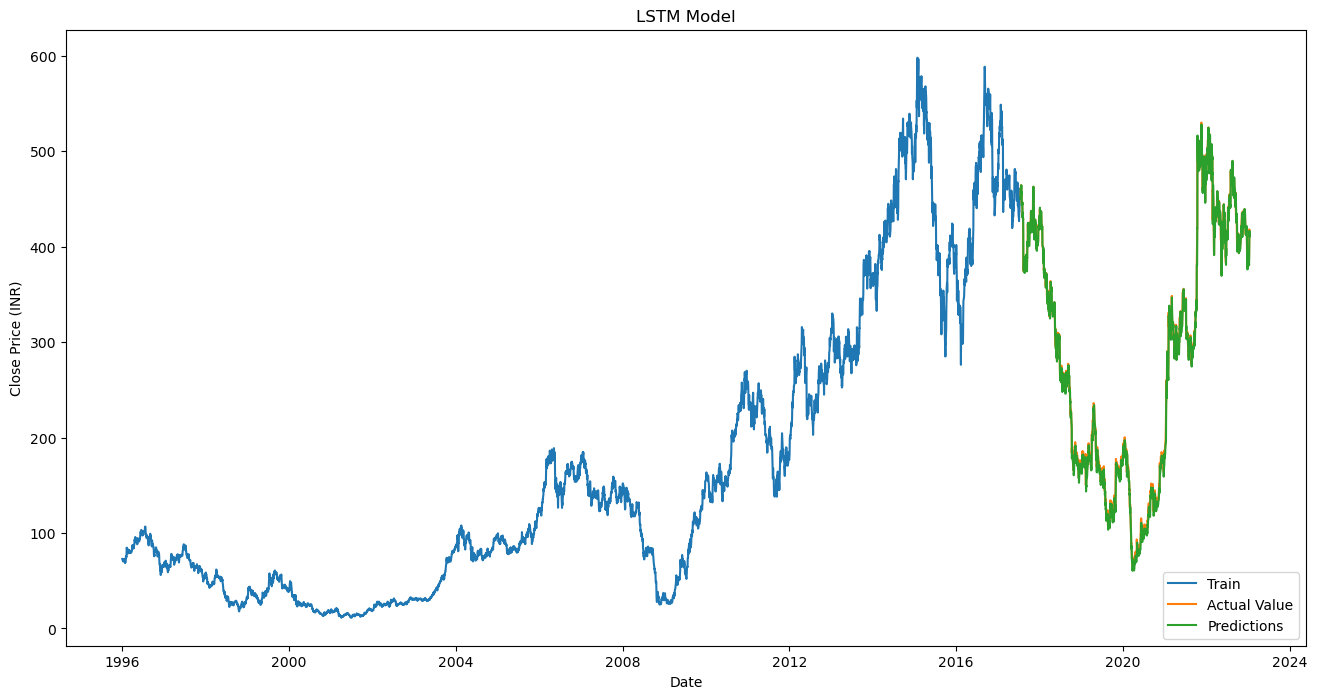

In [11]:
train = new_data[:train_size]
valid = new_data[train_size:]
valid['Predictions'] = valid_predicted
plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual Value', 'Predictions'], loc='lower right')
plt.show()


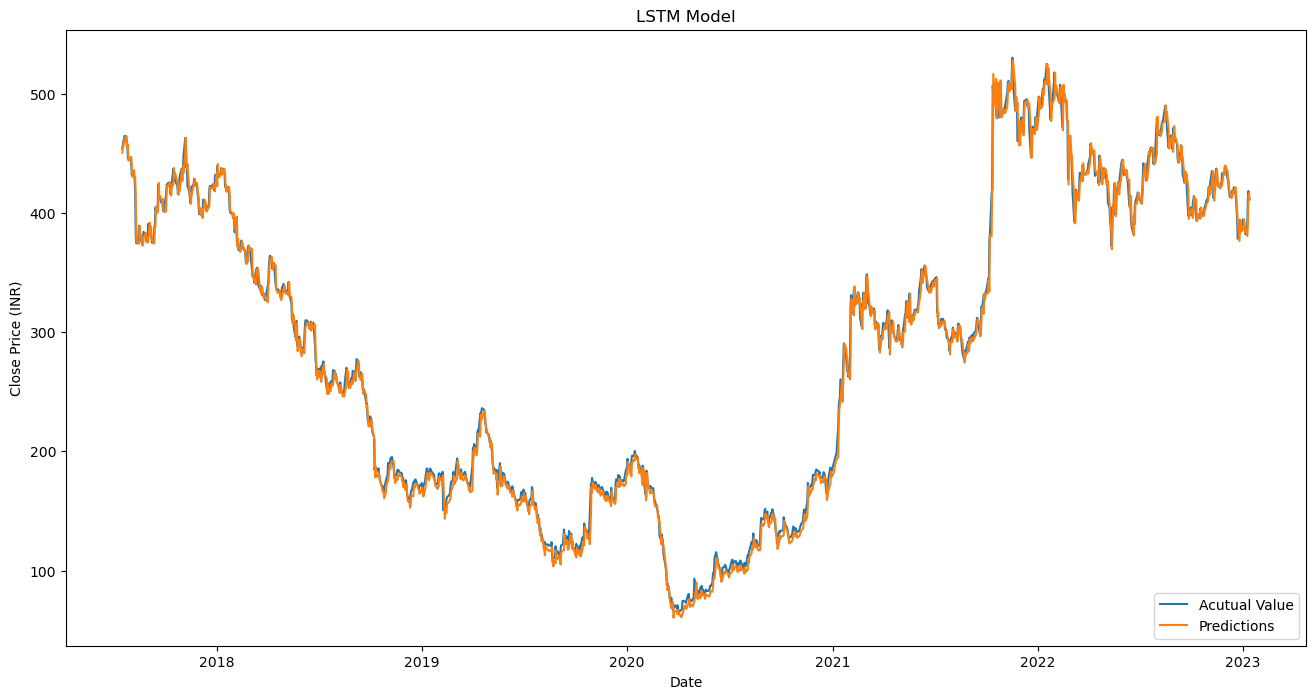

In [12]:
plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.plot(valid[['Close', 'Predictions']])
plt.legend([ 'Acutual Value', 'Predictions'], loc='lower right')
plt.show()
